In [1]:
# Cell 1: imports + load CSV
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

csv_path =  r"C:\Global stat solutions\bidrecommendation.csv"
df = pd.read_csv(csv_path)
print("Loaded:", df.shape, "Columns sample:", df.columns.tolist()[:20])


Loaded: (156733, 51) Columns sample: ['BidId', 'BidFileNumber', 'BidName', 'BidDate', 'Bid_DueDate', 'BidFee', 'TargetTime', 'WinProbability', 'BidStatusName', 'Bid_JobPurpose', 'Bid_Deliverable', 'Market', 'Submarket', 'BusinessSegment', 'BusinessSegmentDetail', 'DistanceInMiles', 'Bid_Property_Type', 'PropertyId', 'OfficeId', 'PropertyName']


In [2]:
# Cell 2: create per-row Win label and parse BidDate
df['BidDate'] = pd.to_datetime(df['BidDate'], errors='coerce')
df = df.dropna(subset=['BidDate']).reset_index(drop=True)

# Prefer BidStatusName; fallback to WinProbability numeric threshold
if 'BidStatusName' in df.columns:
    df['Win'] = df['BidStatusName'].astype(str).str.lower().str.contains('won|awarded|accepted').astype(int)
elif 'WinProbability' in df.columns:
    df['Win'] = (pd.to_numeric(df['WinProbability'], errors='coerce') > 0.5).astype(int)
else:
    raise ValueError("No BidStatusName or WinProbability column to derive Win label.")

print("Win distribution:", df['Win'].value_counts(normalize=True).to_dict())


Win distribution: {1: 0.5013494286461689, 0: 0.49865057135383106}


In [3]:
# Cell 3: weekly aggregation (ZipCode x week) — similar to EDAP approach
df['BidWeekStart'] = df['BidDate'].dt.to_period('W').apply(lambda r: r.start_time)
# numeric conversions
df['BidFee'] = pd.to_numeric(df.get('BidFee'), errors='coerce')
cols_for_agg = {
    'Win': 'mean',                # weekly observed win rate
    'BidFee': 'median',
    'DistanceInMiles': 'mean',
    'IncomePerHousehold': 'mean',
    'AverageHouseValue': 'mean'
}
agg = df.groupby(['ZipCode','BidWeekStart']).agg(cols_for_agg).reset_index()
agg = agg.rename(columns={'Win':'week_win_rate','BidFee':'week_med_fee'})
agg = agg.sort_values(['ZipCode','BidWeekStart']).reset_index(drop=True)
print("Aggregated shape:", agg.shape)
display(agg.head())


Aggregated shape: (68067, 7)


,ZipCode,BidWeekStart,week_win_rate,week_med_fee,DistanceInMiles,IncomePerHousehold,AverageHouseValue
0,0,2018-02-12,0.0,4200.0,51.329228,NaN,NaN
1,0,2018-02-19,0.0,4800.0,1.270172,NaN,NaN
2,0,2018-02-26,0.0,5000.0,5664.063294,NaN,NaN
3,0,2018-03-26,0.0,3250.0,85.476892,NaN,NaN
4,0,2018-04-09,1.0,1612.5,5441.184630,NaN,NaN


In [4]:
# Cell 4: lags and rolling windows (per ZipCode)
for lag in [1,2,3,4]:
    agg[f'win_lag_{lag}'] = agg.groupby('ZipCode')['week_win_rate'].shift(lag)
    agg[f'fee_lag_{lag}'] = agg.groupby('ZipCode')['week_med_fee'].shift(lag)

# rolling mean of win_rate & fee (last 4 weeks, exclude current)
agg['win_roll4'] = agg.groupby('ZipCode')['week_win_rate'].shift(1).rolling(4, min_periods=1).mean().reset_index(level=0, drop=True)
agg['fee_roll4'] = agg.groupby('ZipCode')['week_med_fee'].shift(1).rolling(4, min_periods=1).mean().reset_index(level=0, drop=True)

# drop rows missing essential lags
agg = agg.dropna(subset=['win_lag_1','fee_lag_1']).reset_index(drop=True)
print("After lagging:", agg.shape)
display(agg.head())


After lagging: (58734, 17)


,ZipCode,BidWeekStart,week_win_rate,week_med_fee,DistanceInMiles,IncomePerHousehold,AverageHouseValue,win_lag_1,fee_lag_1,win_lag_2,fee_lag_2,win_lag_3,fee_lag_3,win_lag_4,fee_lag_4,win_roll4,fee_roll4
0,0,2018-02-19,0.0,4800.00,1.270172,NaN,NaN,0.0,4200.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,4200.000000
1,0,2018-02-26,0.0,5000.00,5664.063294,NaN,NaN,0.0,4800.0,0.0,4200.0,NaN,NaN,NaN,NaN,0.00,4500.000000
2,0,2018-03-26,0.0,3250.00,85.476892,NaN,NaN,0.0,5000.0,0.0,4800.0,0.0,4200.0,NaN,NaN,0.00,4666.666667
3,0,2018-04-09,1.0,1612.50,5441.184630,NaN,NaN,0.0,3250.0,0.0,5000.0,0.0,4800.0,0.0,4200.0,0.00,4312.500000
4,0,2018-05-21,1.0,4668.75,5044.069556,NaN,NaN,1.0,1612.5,0.0,3250.0,0.0,5000.0,0.0,4800.0,0.25,3665.625000


In [5]:
# Cell 5: features & label for time-series classification
# We'll predict whether next week's win_rate > threshold (e.g., 0.5)
agg['win_next'] = agg.groupby('ZipCode')['week_win_rate'].shift(-1)
agg = agg.dropna(subset=['win_next']).reset_index(drop=True)
agg['win_next_bin'] = (agg['win_next'] > 0.5).astype(int)

features = [
    'win_lag_1','win_lag_2','win_lag_3','win_roll4',
    'fee_lag_1','fee_lag_2','fee_lag_3','fee_roll4',
    'DistanceInMiles','IncomePerHousehold','AverageHouseValue'
]
# keep only columns that exist
features = [f for f in features if f in agg.columns]
X = agg[features].fillna(0)
y = agg['win_next_bin'].astype(int)

print("Feature count:", len(features), " Sample feature names:", features[:8])
print("Target distribution:", y.value_counts(normalize=True).to_dict())
# scale numeric features (fit later on train in folds; we keep scaler object for simulation)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


Feature count: 11  Sample feature names: ['win_lag_1', 'win_lag_2', 'win_lag_3', 'win_roll4', 'fee_lag_1', 'fee_lag_2', 'fee_lag_3', 'fee_roll4']
Target distribution: {0: 0.523374992973449, 1: 0.476625007026551}


In [6]:
# Cell 6: time-aware CV training of XGBClassifier
tscv = TimeSeriesSplit(n_splits=5)
clf = XGBClassifier(n_estimators=250, max_depth=5, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)

aucs = []
fold_models = []
for i, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    Xtr, Xte = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    ytr, yte = y.iloc[train_idx], y.iloc[test_idx]
    # handle imbalance by scale_pos_weight (optional): ratio = neg/pos in train
    ratio = max(1, int((ytr == 0).sum() / max(1, (ytr == 1).sum())))
    clf.set_params(scale_pos_weight=ratio)
    clf.fit(Xtr, ytr)
    probs = clf.predict_proba(Xte)[:,1]
    auc = roc_auc_score(yte, probs)
    aucs.append(auc); fold_models.append(clf)
    print(f"Fold {i+1} ROC-AUC: {auc:.4f}")
print("Mean AUC:", np.mean(aucs))
# keep last model as final
final_clf = fold_models[-1]


Fold 1 ROC-AUC: 0.6233
Fold 2 ROC-AUC: 0.5405
Fold 3 ROC-AUC: 0.5339
Fold 4 ROC-AUC: 0.5572
Fold 5 ROC-AUC: 0.6784
Mean AUC: 0.5866666041743085


In [7]:
# Cell 7: calibrate probabilities (handles sklearn signature differences)
from sklearn.calibration import CalibratedClassifierCV
import sklearn
print("sklearn version:", sklearn.__version__)

try:
    calibrator = CalibratedClassifierCV(estimator=final_clf, method='isotonic', cv=3)
except TypeError:
    calibrator = CalibratedClassifierCV(base_estimator=final_clf, method='isotonic', cv=3)

try:
    calibrated_clf = calibrator.fit(X_scaled, y)
    print("Calibration succeeded.")
except Exception as e:
    print("Isotonic calibration failed, falling back to sigmoid. Error:", e)
    try:
        calibrator = CalibratedClassifierCV(estimator=final_clf, method='sigmoid', cv=3)
    except TypeError:
        calibrator = CalibratedClassifierCV(base_estimator=final_clf, method='sigmoid', cv=3)
    calibrated_clf = calibrator.fit(X_scaled, y)
    print("Sigmoid calibration succeeded.")


sklearn version: 1.7.2
Calibration succeeded.


In [8]:
# Cell 8: predict next-week win probability per ZipCode (uses last available row per zip)
pred_list = []
for zipc in agg['ZipCode'].unique():
    sub = agg[agg['ZipCode']==zipc].sort_values('BidWeekStart')
    last = sub.iloc[-1]
    # build feature vector from last row (lags already present)
    feat = last[features].fillna(0).values.reshape(1,-1)
    feat_scaled = scaler.transform(feat)
    prob = calibrated_clf.predict_proba(feat_scaled)[:,1][0]
    pred_list.append((zipc, last['BidWeekStart'], prob))

pred_df = pd.DataFrame(pred_list, columns=['ZipCode','WeekStart','Pred_WinProb'])
display(pred_df.head())

# Helper: simulate candidate fees for one ZipCode (sweep over fee grid)
def simulate_fee_for_zip(zipc, fee_grid=None, threshold=0.6):
    sub = agg[agg['ZipCode']==zipc].sort_values('BidWeekStart')
    if len(sub) < 1:
        return None
    last = sub.iloc[-1]
    base = last['week_med_fee'] if 'week_med_fee' in last else np.nan
    if fee_grid is None:
        fee_grid = np.linspace(max(0, base*0.5), base*1.5, 50)
    rows=[]
    for f in fee_grid:
        # create simulated feature vector: replace fee_lag_1 with f (approximation)
        sim = last.copy()
        sim['fee_lag_1'] = f
        # keep other fee lags unchanged (simple heuristic)
        arr = sim[features].fillna(0).values.reshape(1,-1)
        arr_s = scaler.transform(arr)
        p = calibrated_clf.predict_proba(arr_s)[:,1][0]
        rows.append((f,p))
    df_sim = pd.DataFrame(rows, columns=['fee','prob'])
    best = df_sim[df_sim['prob']>=threshold]
    if len(best):
        # choose minimal fee meeting threshold
        chosen = best.sort_values(['fee','prob'], ascending=[True,False]).iloc[0]
        return {"chosen_fee":float(chosen.fee), "pred_prob":float(chosen.prob), "grid":df_sim}
    else:
        top = df_sim.sort_values('prob', ascending=False).iloc[0]
        return {"chosen_fee":float(top.fee), "pred_prob":float(top.prob), "grid":df_sim, "note":"no threshold match"}


,ZipCode,WeekStart,Pred_WinProb
0,0,2025-08-18,0.560890
1,1001,2025-04-07,0.438718
2,1013,2024-09-30,0.420841
3,1022,2020-09-14,0.420841
4,1040,2024-11-25,0.420841


ZIP: 0 result note: ok
Chosen fee: 941.4141414141415 pred_prob: 0.6110073129336039


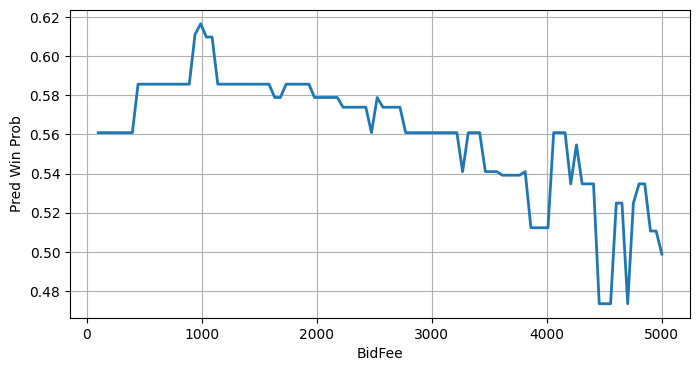

In [9]:
# Cell 9: example usage and plot for one ZIP
zip0 = pred_df['ZipCode'].iloc[0]
res = simulate_fee_for_zip(zip0, fee_grid=np.linspace(100,5000,100), threshold=0.6)
print("ZIP:", zip0, "result note:", res.get('note','ok'))
print("Chosen fee:", res['chosen_fee'], "pred_prob:", res['pred_prob'])
# plot grid
plt.figure(figsize=(8,4)); plt.plot(res['grid']['fee'], res['grid']['prob'], lw=2); plt.xlabel('BidFee'); plt.ylabel('Pred Win Prob'); plt.grid(True); plt.show()
